# Collisional Analysis - Differential Flow

[maruca2013]: https://doi.org/10.1103/PhysRevLett.111.241101
[CoAl]: ../../api_static/plasmapy.formulary.helio.collisional_analysis.rst


This notebook acts as a follow on from the collisional analysis notebook, all functionality is contained within the [collisional_analysis()][CoAl] module. The work done by [Maruca 2013][maruca2013] is expanded upon, instead of analysis the effects of Coulomb collisions on the thermalization of ion temperature ratios, here it is applied to the differential flow between ion species.

The first section will focus on the theroetical framework of collisional analysis and how it was adapted to differetinal flow. The latter section then focus on use of the function and application, the predictions from this technique are also compared with observed values.

## Contents

1. [Mathematical Model](#Mathematical-model)
2. [Usage](#Usage)
3. [Comparision](#Comparision)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random

from astropy import units as u
from hapiclient import hapi

from plasmapy.formulary.collisions.helio import collisional_analysis as coal
from plasmapy.particles import Particle

plt.rcParams["figure.figsize"] = [10.5, 0.56 * 10.5]

[johnson2023a]: https://doi.org/10.3847/1538-4357/accc32
[johnson2023b]: https://
[maruca2013]: https://doi.org/10.1103/PhysRevLett.111.241101
[verscharen2019]: https://doi.org/10.1007/s41116-019-0021-0
[nrl]: https://apps.dtic.mil/sti/pdfs/AD1116543.pdf
[larroche2021]: https://doi.org/10.1140/epjd/s10053-021-00305-2

## Mathematical Model

[Maruca 2013](maruca2013) investiged how Coulomb collisions - "soft," small-angle deflections mediated by the electrostatic force, act to erode non-local thermal equilibrium (LTE) feature within the solar wind. Previous work has focused primarily on ion temperatures, specifically those of protons $(T_{\rm p})$ and $\alpha$-particles $(T_{\rm \alpha})$ [Verscharen 2019](verscharen2019). Following the work by [Johnson 2023a](johnson2023a), the mathematical model for the collisional analysis of differential flow was derived. Begining with the collisional slowing time for two particle species,

$$
    \Delta \vec{v}_{\rm i j} = \vec{v}_{\rm i} - \vec{v}_{\rm j}
$$


our interest lies in the radial evolution of this parameter through the innner heliosphere. To do this, the slowing down rate of test particles streaming with a velocity through a background particle field is considered [NRL](nrl).

$$
    \frac{\Delta \vec{v}_{\rm i j} }{dt} = -\nu^{(\rm ij)} \Delta \vec{v}_{\rm i j}
$$

Here $\nu^{(\rm ij)}$ is the collision rate between the two ion species. When discussing the solar wind, the two species of primary concern as those that are most abundent, protons and $\alpha$-particles. Hence he background particles are taken to be protons and the proton velocity is the streaming velocity of the background particle field. Thus following the example in [Maruca 2013](maruca2013) the chain rule can be applied and the proton velocity subsituted as follows:

$$
    \frac{\Delta \vec{v}_{\alpha \rm p} }{dr} =   \frac{\Delta \vec{v}_{\alpha \rm p} }{dt} \cdot \frac{dt}{dr} = \frac{\Delta \vec{v}_{\alpha \rm p} }{dt} \cdot \frac{1}{|\vec{v}_{\rm p}|} = -\nu^{(\alpha \rm p)}  \frac{\Delta \vec{v}_{\alpha \rm p}}{|\vec{v}_{\rm p}|}
$$

The formulation of the collision rate, $\nu^{(\rm ij)}$, is derived from the velocity distrubtion function for the two colliding ion species [Larroche 2021](larroche2021), i.e. protons and $\alpha$-particles. Resulting in the following equation for collisional analysis of differential flow:

$$
    \frac{\Delta \vec{v}_{\alpha \rm p} }{dr} = - \frac{4\sqrt{2\pi} \, e^{4} Z^{2}_{\alpha} Z^{2}_{\rm p}(m_{\alpha} + m_{\rm p})(n_{\alpha}m_{\alpha} + n_{\rm p}m_{\rm p})\, \lambda_{\alpha \rm p}}{3m_{\alpha}^{2}m_{\rm p}^{2}(4\pi \epsilon_{0})^{2}\left( \frac{k_{B}T_{\alpha}}{m_{\alpha}} + \frac{k_{B}T_{\rm p}}{m_{\rm p}} \right)^{3/2}} \cdot \frac{\Delta \vec{v}_{\alpha \rm p}}{|\vec{v}_{\rm p}|}
$$


<div class="alert alert-info">

Assumptions

This model assumed the following conditions:

  * $\eta_{\alpha \rm p}$ remains fixed within any given parcel of plasma
  * The system is in a steady state
  * No relative drift between ion species
  * All particles are fully ionized

</div>

We can demonstrate how the differential flow varies over distance by modeling the characteristic decay curves, this allows us to predict the differential flow at different distances. Let us model the evolution of the differntial flow:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


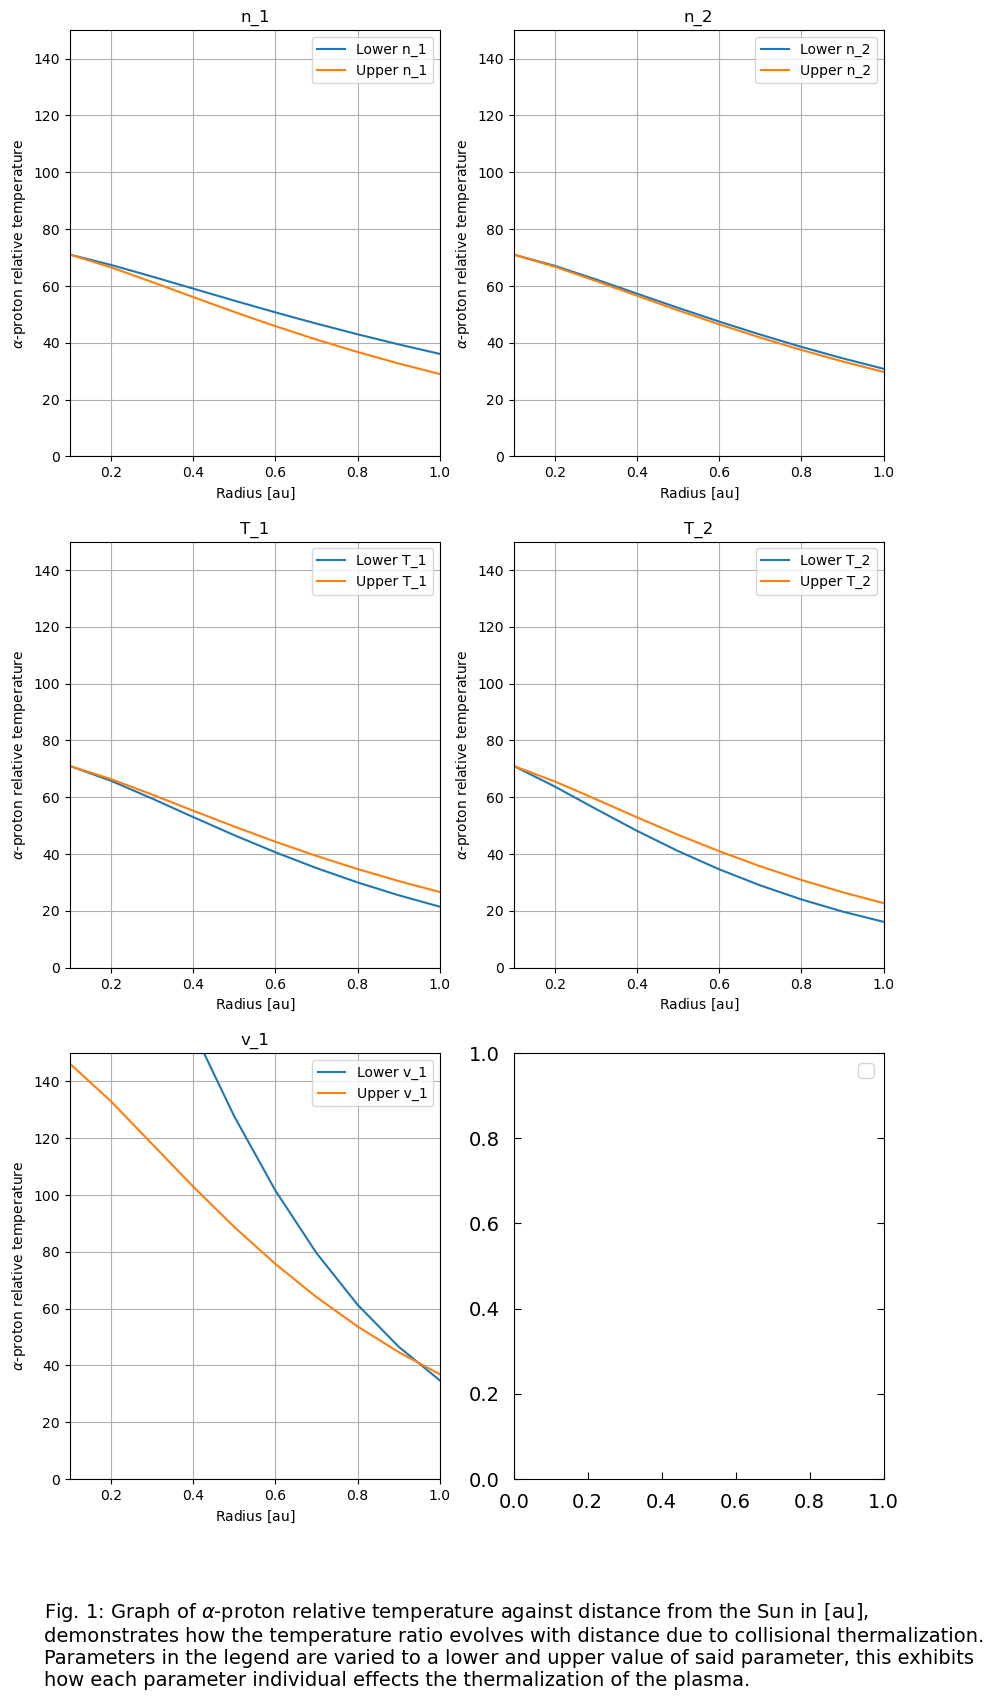

In [5]:
theta = {}
mm_vals = {}

# Define the location, i.e. the starting point where parameters were observed in [au]
r_start = 0.1
r_end = 1.1
radii = np.arange(r_start, r_end, 0.1).tolist()

# Define typical values for parameters within the solar wind
n_p_min = 100
n_p_max = 150

n_a_min = 5
n_a_max = 15

v_p_min = 300
v_p_max = 500

v_a_min = 400
v_a_max = 700

B_min = 0.1
B_max = 1

T_p = 10**5
T_a = 10**6

# Define parameters


def gen_params():
    params = {
        "r_0": [r_start] * u.au,
        "r_n": [r_end] * u.au,
        "n_1": [random.randint(n_p_min, n_p_max)] * u.cm**-3,
        "n_2": [random.randint(n_a_min, n_a_max)] * u.cm**-3,
        "v_1": [random.randint(v_p_min, v_p_max)] * u.km / u.s,
        "v_2": [random.randint(v_a_min, v_a_max)] * u.km / u.s,
        "T_1": [(1 + random.random()) * T_p] * u.K,
        "T_2": [(1 + random.random()) * T_a] * u.K,
        "ions": ["p+", "He-4++"],
        "B": [random.uniform(B_min, B_max)] * u.nT,
        "n_step": 10,
        "second_scale":False,
    }
    return params

# Ensure generated parameters are consistent with observations
def check_params(
    params,
):
    if abs(float(params["v_2"].value) - float(params["v_1"].value)) > 125:
        return False
    elif params["T_2"]/params["T_1"] > 14:
        return False
    else:
        return True

params = gen_params()
while check_params(params) is False:
    params = gen_params()


p_vals = ("n_1", "n_2", "T_1", "T_2", "v_1")

# Calculate theta for the given parameters
for param in p_vals:  # Vary certain parameters so we can see their individual affect
    mm_vals[param] = (
        0.6,
        1.4,
    )  # Generate upper and lower values to vary each parameter
    theta[param] = {}
    for mm_val in mm_vals[param]:
        theta[param][mm_val] = []
        params[str(param)][0] = params[str(param)][0] * mm_val
        for radius in radii:
            params["r_n"] = [radius] * u.au
            theta[param][mm_val].append(coal.diff_flow(**params)[0].value)

# Plot the results
fs = 14  # Default font size
figwidth, figheight = plt.rcParams["figure.figsize"]
figheight = 3.2 * figheight
fig, axis = plt.subplots(3, 2, figsize=(figwidth, figheight))

j = 0
for i, param in enumerate(p_vals):
    i = int(i / 2)

    if j > 1:
        j = 0

    for mm_val in theta[param]:
        if mm_val < 1:
            lbl = "Lower"
        else:
            lbl = "Upper"
        lbl = lbl + " " + param
        axis[i, j].plot(radii, theta[param][mm_val], label=lbl)
        axis[i, j].legend(loc="upper right")
        axis[i, j].set_title(param)
        axis[i, j].set_xlabel(r"Radius $[\rm au]$")
    axis[i, j].set_xlim(0.1, 1)
    axis[i, j].set_ylim(0, 150)
    axis[i, j].grid()
    axis[i, j].set_ylabel(r"$\alpha$-proton relative temperature")
    j = j + 1

plt.tick_params(
    which="both",
    direction="in",
    labelsize=fs,
    right=True,
    length=5,
    pad=10,
)

# Plot caption
txt = (
    r"Fig. 1: Graph of $\alpha$-proton relative temperature against distance from the Sun in [au], "
    f"\ndemonstrates how the temperature ratio evolves with distance due to collisional thermalization. \nParameters in the legend are varied to a lower and upper value of said parameter, this exhibits \nhow each parameter individual effects the thermalization of the plasma."
)

plt.figtext(0.1, -0.00, txt, ha="left", fontsize=fs)
plt.legend(loc="upper right", fontsize=fs)

plt.show()


<div class="alert alert-info">

Note:

The model allows parameters to vary with $r$. In particular, [Maruca 2013](maruca2013) used the following radial scaling based on the analysis of Helios observations by [Hellinger 2011](hellinger2011):

$$
    n_{\rm p}(r) \propto r^{-1.8}\ , \hspace{1cm} v_{r\rm p}(r) \propto r^{-0.2}\ , T_{\rm p}(r) \propto r^{-0.74} \hspace{0.5cm} {\rm and} \hspace{0.5cm} B(r) \propto r^{-1.6}
$$

These values are not fixed and can be altered within the function, they can be taken from simulations, data or both.

</div>

 99.90 %

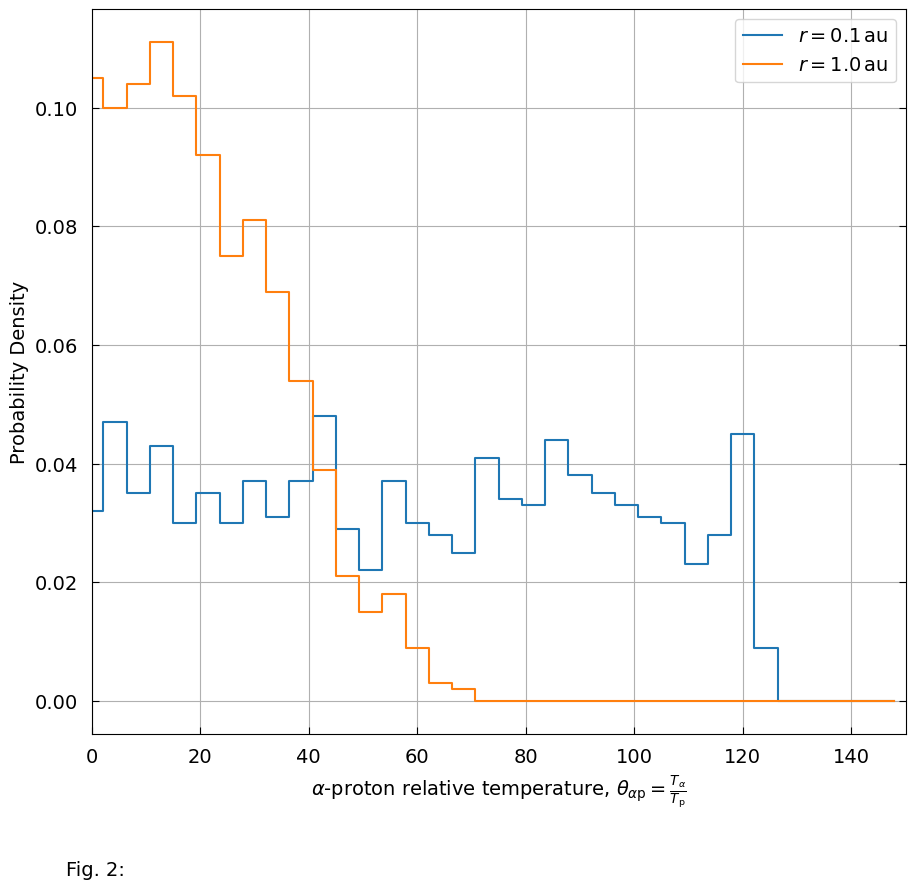

In [3]:
# Functionality to display histograms
def make_bars(
    x,
    y,
    width,
):
    xs = [x[0] - width]
    ys = [0]
    for i in range(len(x)):
        xs.append(x[i] - width)
        xs.append(x[i] + width)
        ys.append(y[i])
        ys.append(y[i])
    xs.append(x[-1] + width)
    ys.append(y[-1])

    return xs, ys


# Define arrays
theta = []
theta_pred = []

# Generate theta values for inputs and prediction
L = 1000  # The number of values you want to produce
for i in range(L):
    params = gen_params()
    while check_params(params) is False:
        params = gen_params()
    theta.append(float(abs(params["v_2"] - params["v_1"]).value))
    theta_pred.append(coal.diff_flow(**params)[0].value)
    print("\r", f"{(i / L) * 100:.2f} %", end="")

# Define constraints
xlim = 150
bin_num = 35

# Plot the results
fs = 14  # Default font size
figwidth, figheight = plt.rcParams["figure.figsize"]
figheight = 1.6 * figheight
fig = plt.figure(figsize=[figwidth, figheight])

weg = np.ones_like(theta) / float(len(theta))
results, edges = np.histogram(
    theta, range=(0, xlim), weights=weg, bins=bin_num, density=1
)
binWidth = edges[1] - edges[0]
xs, ys = make_bars(edges[:-1], results * binWidth, binWidth / 2)
plt.plot(xs, ys, label=r"$r = 0.1 \, {\rm au}$")

weg = np.ones_like(theta_pred) / float(len(theta_pred))
results, edges = np.histogram(
    theta_pred, range=(0, xlim), weights=weg, bins=bin_num, density=1
)
binWidth = edges[1] - edges[0]
xs, ys = make_bars(edges[:-1], results * binWidth, binWidth / 2)
plt.plot(xs, ys, label=r"$r = 1.0 \, {\rm au}$")

# Adjust axes
plt.ylabel(r"Probability Density", fontsize=fs)
plt.xlabel(
    r"$\alpha$-proton relative temperature, $\theta_{\alpha \rm p} = \frac{T_{\alpha}}{T_{\rm p}}$",
    fontsize=fs,
)
plt.xlim(0, 150)

plt.tick_params(
    which="both",
    direction="in",
    labelsize=fs,
    right=True,
    length=5,
    pad=10,
)

# Plot caption
txt = (
    r"Fig. 2: "
)

plt.legend(loc="upper right", fontsize=fs)
plt.figtext(0.1, -0.04, txt, ha="left", fontsize=fs)
plt.grid()
plt.show()
